In [1]:
import time
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
import pandas as pd
from scipy.special import erfc
import matplotlib.cm as cm
import pickle
from matplotlib.ticker import MaxNLocator

plt.rcParams.update({'font.size': 12})

In [2]:
#initial parameters
N = 50
L = 1.0
dx = L / N
tolerance = 1e-6
max_iter = 10000
omega = 1.8


In [3]:

# initialize grid
def initialize_grid(N):
    c = np.zeros((N+1, N+1))
    c[:, -1] = 1.  # 右边界
    return c

# error calculation
def calculate_error(new_c, old_c):
    return np.max(np.abs(new_c - old_c))

# boundary update
def update_boundary(c):
    c[0, :] = c[-2, :]
    c[-1, :] = c[1, :]
    c[:, 0] = 0.
    c[:, -1] = 1.
    return c

# Jacobi iteration
def jacobi_method(c0, tolerance=tolerance, max_iter=max_iter):
    c, c_new = c0.copy(), c0.copy()
    errors = []
    for _ in range(max_iter):
        # update inner points
        c_new[1:-1, 1:-1] = 0.25 * (c[2:, 1:-1] + c[:-2, 1:-1] + c[1:-1, 2:] + c[1:-1, :-2])
        # update boundary
        c_new = update_boundary(c_new)
        # error calculation
        error = calculate_error(c_new, c)
        errors.append(error)
        # convergence check
        if error < tolerance:
            break
        c, c_new = c_new, c      
    return c, errors


# Gauss-Seidel iteration
def gauss_seidel_method(c0, tolerance=tolerance, max_iter=max_iter):
    c = c0.copy()
    errors = []
    for _ in range(max_iter):
        old_c = c.copy()
        # same as Jacobi, but update in place
        for i in range(1, N):
            for j in range(1, N):
                c[i, j] = 0.25 * (c[i+1, j] + c[i-1, j] + c[i, j+1] + c[i, j-1])
        c = update_boundary(c)
        error = calculate_error(c, old_c)
        errors.append(error)
        if error < tolerance:
            break     
    return c, errors

# SOR iteration
def sor_method(c0, omega, tolerance=tolerance, max_iter=max_iter):
    c = c0.copy()
    errors = []
    for _ in range(max_iter):
        old_c = c.copy()
        # same as Gauss-Seidel, but with relaxation
        for i in range(1, N):
            for j in range(1, N):
                new_value = 0.25 * (c[i+1, j] + c[i-1, j] + c[i, j+1] + c[i, j-1])
                c[i, j] = (1 - omega) * c[i, j] + omega * new_value
        c = update_boundary(c)
        error = calculate_error(c, old_c)
        errors.append(error)
        if error < tolerance:
            break       
    return c, errors



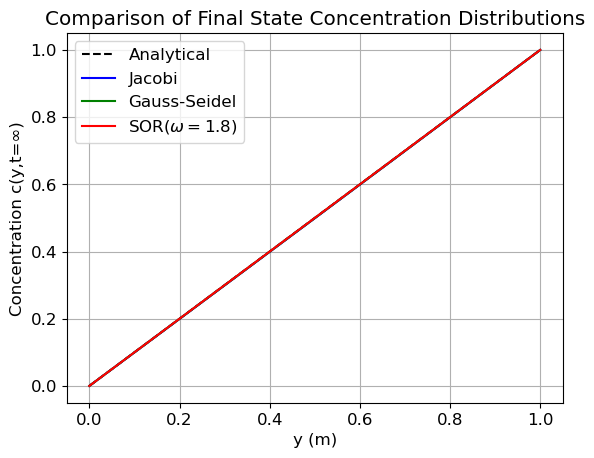

In [4]:
#It's time to run the SIMULATION!
c0 = initialize_grid(N)
c_jacobi, errors_jacobi = jacobi_method(c0)
c_gauss_seidel, errors_gauss_seidel = gauss_seidel_method(c0)
c_sor, errors_sor = sor_method(c0, omega)

# plot numerical methods with analytical solution
xs = np.linspace(0, 1, N+1)
plt.figure()
plt.plot(xs, xs, label='Analytical', linestyle='--', color='black')
plt.plot(xs, c_jacobi[0, :], label='Jacobi', color='blue')
plt.plot(xs, c_gauss_seidel[0, :], label='Gauss-Seidel', color='green')
plt.plot(xs, c_sor[0, :], label=f'SOR($\\omega={omega}$)', color='red')
plt.xlabel('y (m)')
plt.ylabel('Concentration c(y,t=∞)')
plt.title('Comparison of Final State Concentration Distributions')
plt.legend()
plt.grid(True)
plt.show()

### I. (1 point) Show how the convergence measure $\delta$ in equation $\delta \equiv \max_{i, j} \left| c_{i, j}^{k+1} - c_{i, j}^{k} \right| < \epsilon$ depends on the number of iterations $k$ for each of the methods. 
A log-lin plot may be suitable. For SOR, choose a few representative values for $\omega$.



In [5]:
omegas = np.array([1.75, 1.8, 1.85, 1.9, 1.95])  # Selected different omegas and text for tolerance

# Updata for Jacobi with $\delta$ like eq.(14)
def jacobi_method(c0, tolerance=tolerance, max_iter=max_iter):
    c, c_new = c0.copy(), c0.copy()
    deltas = []  # Record convergence measure
    for _ in range(max_iter):
        c_new[1:-1, 1:-1] = 0.25 * (c[2:, 1:-1] + c[:-2, 1:-1] + c[1:-1, 2:] + c[1:-1, :-2])
        c_new = update_boundary(c_new)
        delta = np.max(np.abs(c_new - c))
        deltas.append(delta)  # Same record
        if delta < tolerance:
            break
        c, c_new = c_new, c
    return c, deltas

# Update for Gauss-Seidel 
def gauss_seidel_method(c0, tolerance=tolerance, max_iter=max_iter):
    c = c0.copy()
    deltas = []  # same record
    for _ in range(max_iter):
        old_c = c.copy()
        for i in range(1, N):
            for j in range(1, N):
                c[i, j] = 0.25 * (c[i+1, j] + c[i-1, j] + c[i, j+1] + c[i, j-1])
        c = update_boundary(c)
        delta = np.max(np.abs(c - old_c))
        deltas.append(delta)  # same record
        if delta < tolerance:
            break
    return c, deltas

# Update for SOR 
def sor_method(c0, omega, tolerance=tolerance, max_iter=max_iter):
    c = c0.copy()
    deltas = []  # same record
    for _ in range(max_iter):
        old_c = c.copy()
        for i in range(1, N):
            for j in range(1, N):
                new_value = 0.25 * (c[i+1, j] + c[i-1, j] + c[i, j+1] + c[i, j-1])
                c[i, j] = (1 - omega) * c[i, j] + omega * new_value
        c = update_boundary(c)
        delta = np.max(np.abs(c - old_c))
        deltas.append(delta)  #same record
        if delta < tolerance:
            break
    return c, deltas

# Main Simulation and Recording Deltas
c0 = initialize_grid(N)
_, deltas_jacobi = jacobi_method(c0)
_, deltas_gs = gauss_seidel_method(c0)

# SOR with different omegas
deltas_sors = []
converged = np.ones_like(omegas)
for omega in omegas:
    _, deltas_sor = sor_method(c0, omega)
    if len(deltas_sor) == max_iter and deltas_sor[-1] > tolerance:
        converged[omegas == omega] = 0
    else:
        deltas_sors.append(deltas_sor)

if np.any(converged == 0):
    print("\nThe following ω values did not converge after 10000 iterations:")
    print(omegas[converged == 0])
else:
    print("\nAll ω values converged successfully.")


The following ω values did not converge after 10000 iterations:
[1.95]


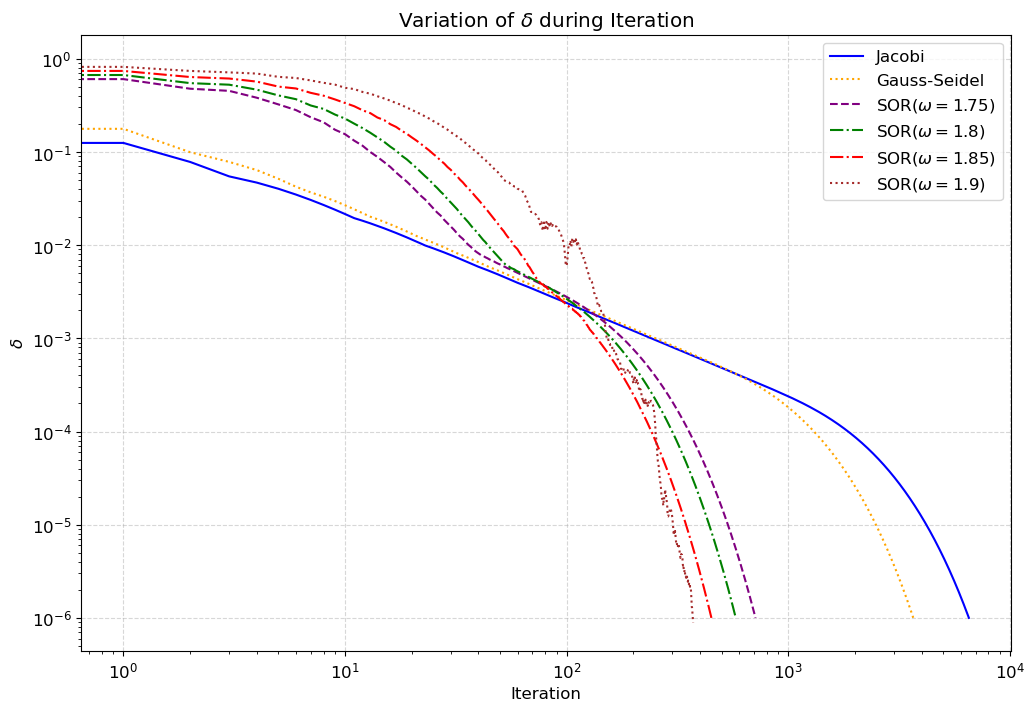

In [6]:
# Plot Log-Log Convergence (Iteration vs δ)
plt.figure(figsize=(12, 8))
plt.loglog(deltas_jacobi, label='Jacobi', color='blue', linestyle='-')
plt.loglog(deltas_gs, label='Gauss-Seidel', color='orange', linestyle=':')
styles = ['--', '-.', '-.', ':', ':']
colors = ['purple', 'green', 'red', 'brown', 'gray']
for i, omega in enumerate(omegas):
    if converged[i]:
        plt.loglog(deltas_sors[i], label=f'SOR($\\omega={omega}$)', color=colors[i], linestyle=styles[i])
plt.xlabel('Iteration')
plt.ylabel(r'$\delta$')
plt.title('Variation of $\delta$ during Iteration')
plt.legend()
plt.grid(True, which="major", linestyle='--', alpha=0.5)  # Only major grid lines, lighter
plt.show()


### J. (1 point) In the SOR method, find the optimal $\omega$. How does it depend on $N$?

 1. Finding Optimal Omega

SOR method with omega=1.94 did not converge after 10000 iterations!

Converged Omegas: [1.85 1.86 1.87 1.88 1.89 1.9  1.91 1.92 1.93]
Iterations: [451, 426, 400, 374, 353, 373, 502, 741, 1685]


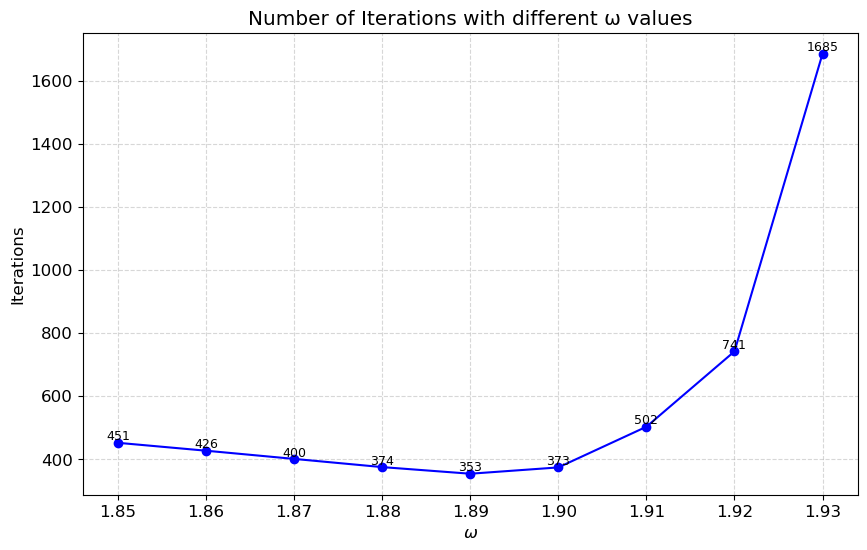

In [ ]:
omegas = np.round(np.arange(1.85, 1.95, 0.01), 3)

iterations = []
converged = np.ones_like(omegas).astype(bool)

# Run SOR for each omega value
for i, omega in enumerate(omegas):
    try:
        _, deltas_sor = sor_method(initialize_grid(N), omega=omega, tolerance=tolerance, max_iter=max_iter)
    except Exception as e:
        print("An error occurred:", e)
        converged[i] = 0
    else:
        if len(deltas_sor) == max_iter:
            print(f"SOR method with omega={omega} did not converge after {max_iter} iterations!")
            converged[i] = 0
        else:
            iterations.append(len(deltas_sor))

print("\nConverged Omegas:", omegas[converged])
print("Iterations:", iterations)

# Plot iterations vs. omega with annotations
plt.figure(figsize=(10, 6))
plt.plot(omegas[converged], iterations, 'o-', color='blue')
for i, (omega, iters) in enumerate(zip(omegas[converged], iterations)):
    plt.text(omega, iters, f'{iters}', ha='center', va='bottom', fontsize=9)
plt.xlabel(r'$\omega$')
plt.ylabel('Iterations')
plt.title('Number of Iterations with different ω values')
plt.grid(True, linestyle='--', alpha=0.5)
plt.show()



2. Optimal Omega Depend on N


Grid Sizes (N): [30, 40, 50, 60, 70, 80]
Optimal Omegas: [1.85, 1.87, 1.89, 1.91, 1.92, 1.93]


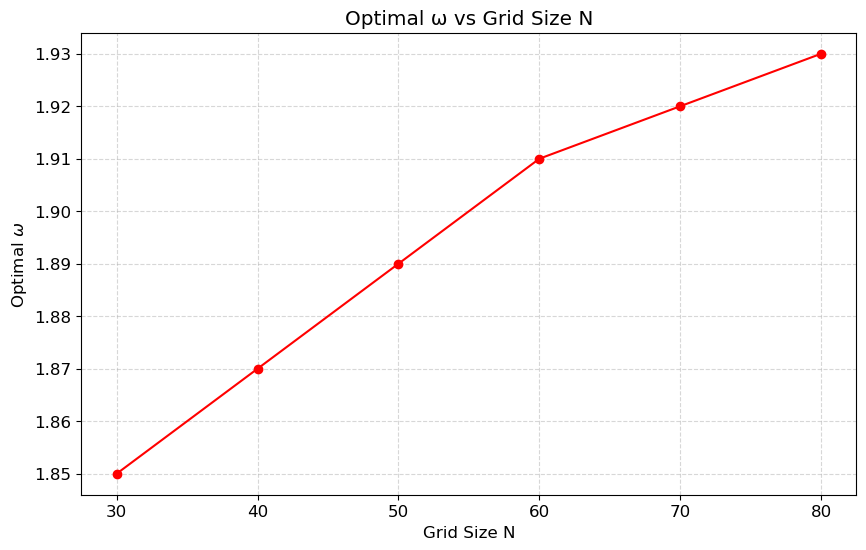

In [ ]:

Ns = [30, 40, 50, 60, 70, 80]
optimal_omegas = []

for N in Ns:
    c0 = initialize_grid(N)
    iterations = []
    converged = np.ones_like(omegas).astype(bool)
    for i, omega in enumerate(omegas):
        try:
            _, deltas_sor = sor_method(c0, omega=omega, tolerance=tolerance, max_iter=max_iter)
        except Exception as e:
            converged[i] = 0
        else:
            if len(deltas_sor) == max_iter:
                converged[i] = 0
            else:
                iterations.append(len(deltas_sor))
    # Find optimal omega for this N
    optimal_omegas.append(omegas[converged][np.argmin(iterations)])

print("\nGrid Sizes (N):", Ns)
print("Optimal Omegas:", optimal_omegas)

# Plot Optimal Omega vs N
plt.figure(figsize=(10, 6))
plt.plot(Ns, optimal_omegas, 'o-', color='red')
plt.xlabel('Grid Size N')
plt.ylabel(r'Optimal $\omega$')
plt.title('Optimal ω vs Grid Size N')
plt.grid(True, linestyle='--', alpha=0.5)
plt.show()


So far we have only looked at diffusion in a rather dull domain. Now that we have an efficient iterative solver available, it’s time to start including some object into the domain. So, now we assume that within our computational domain we include say a square object. We assume that the object is a sink for the diffusion concentration, that is, the concentration is zero everywhere on the object.


### K. (2 points) Implement the possibility to include objects into the computational domain.
The objects should be sinks. Experiment a little bit with some objects in the computational domain (e.g. a rectangle or a few rectangles, ...). What is the
influence on the number of iterations. What about the optimal $\omega$, is it influenced by the presence of objects? Look at the resulting concentration fields, and try to interpret what happens. The implementation in this exercise will also be used for diffusion-limited aggregation in Set 2.


Hint: For the iterations, the presence of the objects is not complicated. If a point
(i, j) is part of an object, the concentration is just 0, and an iteration is not necessary
(i.e., the new value is also 0). Therefore, you must implement some easy encoding
of the object in the computational grid, and during the iterations simply test if the
grid point that you are updating is part of the object or not. If not, you apply the
SOR rule, if yes, just put the new value to zero. The easiest encoding is just an
extra array of integers, where e.g. a one-value would code for the presence of an
object, and a zero value for the absence of an object

In [14]:
N = 50
tolerance = 1e-6
max_iter = 10000
omegas = np.round(np.arange(1.80, 2.00, 0.01), 3) 

#Initialize Info again
def initialize_grid(N):
    c = np.zeros((N+1, N+1))
    c[:, -1] = 1.  # 右边界
    return c

def update_boundary(c):
    c[0, :] = c[-2, :]
    c[-1, :] = c[1, :]
    c[:, 0] = 0.
    c[:, -1] = 1.
    return c

# SOR sink with objects
def SOR_sink_obj(c0, omega, objects, tolerance=tolerance, max_iter=max_iter):
    assert objects.shape == c0.shape, "The objects must have the same shape as the concentration grid."
    N = c0.shape[0]
    c = c0.copy()
    c[objects] = 0.
    deltas = []
    for _ in range(max_iter):
        c[:, -1] = 1.
        c[:, 0] = 0.
        c[0, :] = c[-2, :]
        c[-1, :] = c[1, :]
        delta = 0.
        for i in range(1, N-1):
            for j in range(1, N-1):
                if objects[i, j]: 
                    c[i, j] = 0
                    continue
                old_c = c[i, j]
                c[i, j] = omega * 0.25 * (c[i-1, j] + c[i+1, j] + c[i, j-1] + c[i, j+1]) + (1 - omega) * c[i, j]
                delta = max(delta, abs(c[i, j] - old_c))
        deltas.append(delta)
        if delta <= tolerance:
            break
    return c, np.array(deltas)
c0 = initialize_grid(N)



In [20]:
# No Object (0)
objects0 = np.zeros((N+1, N+1), dtype=bool)  # No object

# One Square
objects1 = np.zeros((N+1, N+1), dtype=bool)
objects1[2*N//5:3*N//5, 2*N//5:3*N//5] = True

# Two Squares
objects2 = np.zeros((N+1, N+1), dtype=bool)
objects2[N//5:2*N//5, 2*N//5:3*N//5] = True
objects2[3*N//5:4*N//5, 2*N//5:3*N//5] = True

# Three Squares
objects3 = np.zeros((N+1, N+1), dtype=bool)
objects3[2*N//5:3*N//5, 3*N//5:4*N//5] = True
objects3[N//5:2*N//5, N//5:2*N//5] = True
objects3[3*N//5:4*N//5, N//5:2*N//5] = True

# Four Squares
objects4 = np.zeros((N+1, N+1), dtype=bool)
objects4[N//5:2*N//5, N//5:2*N//5] = True
objects4[3*N//5:4*N//5, N//5:2*N//5] = True
objects4[N//5:2*N//5, 3*N//5:4*N//5] = True
objects4[3*N//5:4*N//5, 3*N//5:4*N//5] = True

#Experimenting with Different Object Configurations
obj_configs = [objects0, objects1, objects2, objects3, objects4]
optimal_omegas = []
iterations = []

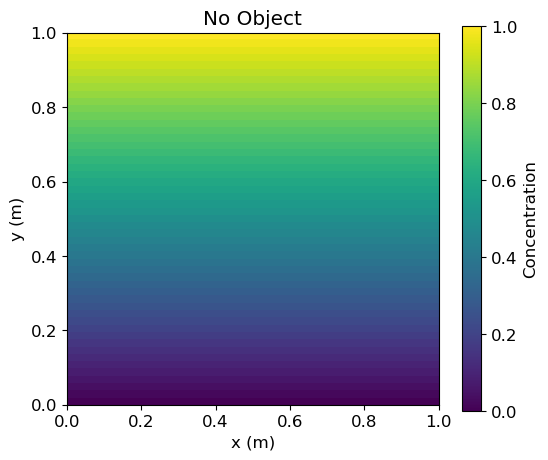

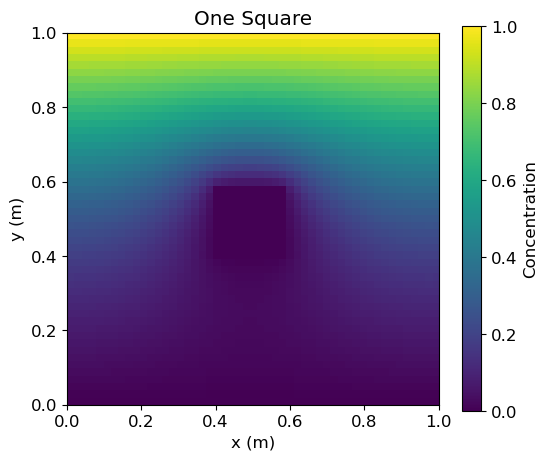

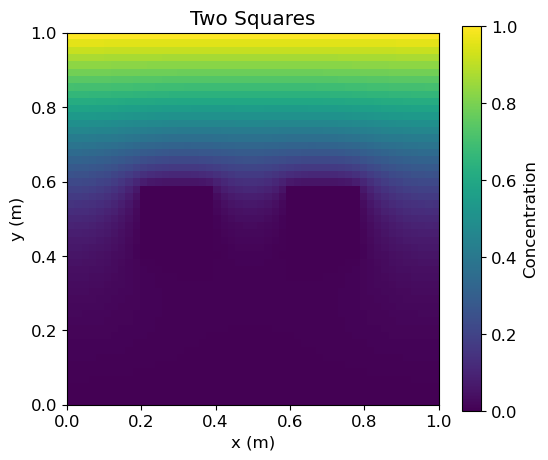

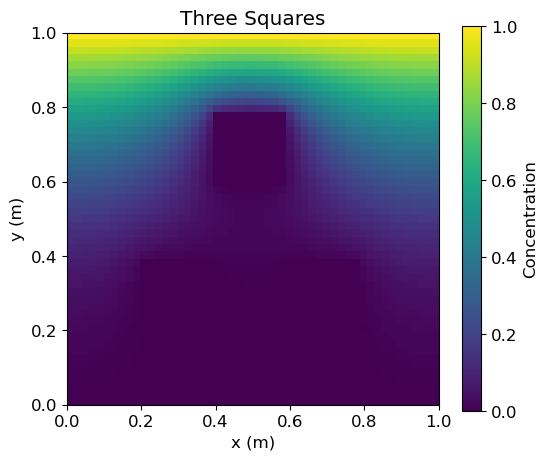

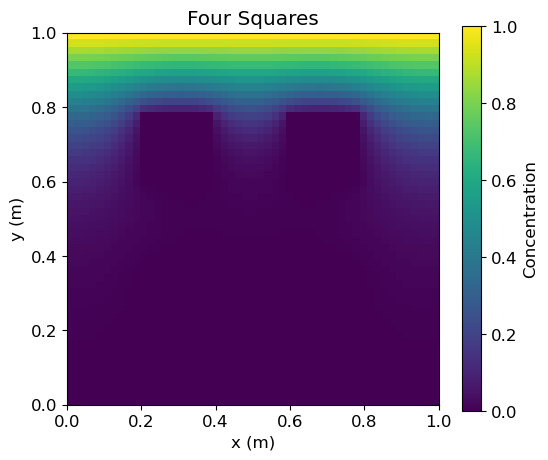

In [16]:

config_types = ['No Object', 'One Square', 'Two Squares', 'Three Squares', 'Four Squares']
# Loop through each configuration and plot the concentration field
for idx, obj in enumerate(obj_configs):
    c0 = initialize_grid(N)
    c, _ = SOR_sink_obj(c0, omega=1.89, objects=obj)
    
    plt.figure(figsize=(6, 5))
    plt.imshow(c.T, extent=(0, 1, 0, 1), origin='lower', cmap=cm.viridis)
    plt.xlabel('x (m)')
    plt.ylabel('y (m)')
    plt.title(config_types[idx])
    plt.colorbar(label='Concentration')
    plt.grid(False)  # No grid for better visualization
    plt.show()


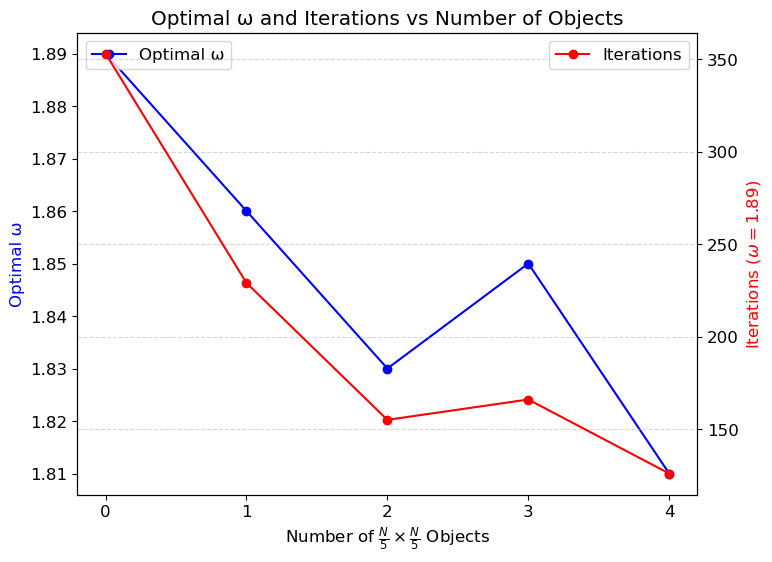

In [ ]:
optimal_omegas = [1.89, 1.86, 1.83, 1.85, 1.81]
obj_nums = [0, 1, 2, 3, 4]
fig, ax1 = plt.subplots(figsize=(8, 6))
ax1.set_xlabel(r'Number of $\frac{N}{5}\times\frac{N}{5}$ Objects')
ax1.plot(obj_nums, optimal_omegas, 'o-', label='Optimal ω', color='blue')
ax1.set_ylabel('Optimal ω', color='blue')
ax2 = ax1.twinx()
ax2.plot(obj_nums, [min(iters) for iters in iterations], 'o-', label='Iterations', color='red')
ax2.set_ylabel('Iterations ($\omega = 1.89$)', color='red')
ax1.legend(loc='upper left')
ax2.legend(loc='upper right')
ax1.xaxis.set_major_locator(MaxNLocator(integer=True))
plt.grid(True, linestyle='--', alpha=0.5)
plt.title('Optimal ω and Iterations vs Number of Objects')
plt.show()
